# Processing and narrating a video with GPT's visual capabilities and the TTS API

https://github.com/openai/openai-cookbook/blob/main/examples/GPT_with_vision_for_video_understanding.ipynb

This notebook demonstrates how to use GPT's visual capabilities with a video. GPT-4 doesn't take videos as input directly, but we can use vision and the new 128K context window to describe the static frames of a whole video at once. We'll walk through two examples:

1. Using GPT-4 to get a description of a video
2. Generating a voiceover for a video with GPT-4 and the TTS API


In [2]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os
import requests
from dotenv import load_dotenv

load_dotenv()

HUME_API_KEY = os.getenv("HUME_API_KEY")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY", "<your OpenAI API key if not set as env var>"))

## 1. Using GPT's visual capabilities to get a description of a video


First, we use OpenCV to extract frames from a nature [video](https://www.youtube.com/watch?v=kQ_7GtE529M) containing bisons and wolves:


In [9]:
video = cv2.VideoCapture("bison.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

KeyboardInterrupt: 

Display frames to make sure we've read them in correctly:


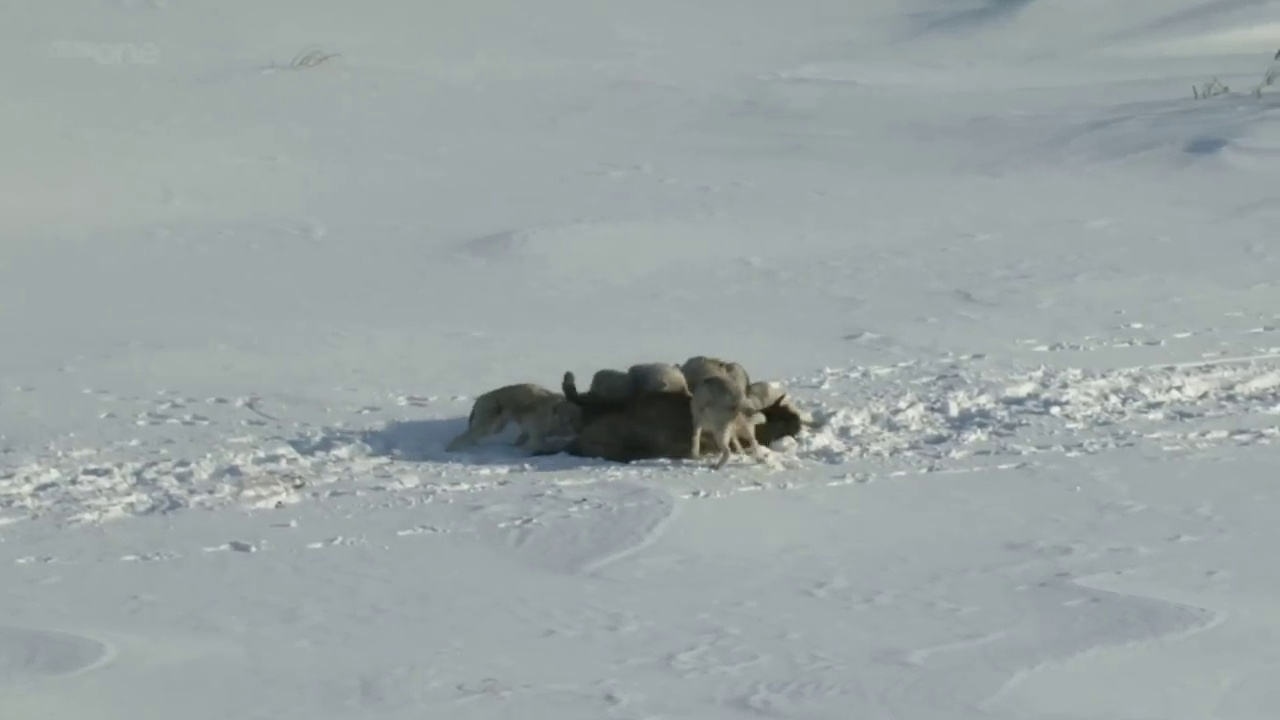

In [5]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

Once we have the video frames, we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):


In [6]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

"Survival of the Fittest: A Heart-Stopping Encounter in the Snow"

Witness the raw power and perilous struggle of nature in this gripping video showcasing the intense battle between a pack of wolves and a bison in the snowy wild. Watch as the formidable bison defends itself against the determined predators, showcasing the harsh realities of survival in the wild. Each frame captures the tension, drama, and unpredictability of this extraordinary wildlife encounter. Don't miss the chance to immerse yourself in the mesmerizing and often brutal dance of predator and prey, where only the strongest survive.


## 2. Generating a voiceover for a video with GPT-4 and the TTS API


Let's create a voiceover for this video in the style of David Attenborough. Using the same video frames we prompt GPT to give us a short script:


In [7]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of David Attenborough. Only include the narration.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::60]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)

In the frigid heart of winter, where the white expanse rules supreme, the stark contrast of life and death paints a dramatic tale. Here, we witness one of nature's most exhilarating spectacles: the struggle for survival. A pack of wolves, the consummate predators of the north, is on the hunt, guided by instinct and honed by generations of selection.

Their target, a formidable bison, is no easy prey. Powerfully built, with heavy fur and a massive frame, the bison is a bastion of strength, but in this harsh realm, even the mighty can fall. The wolves, agile and relentless, work in unison, a symphony of strategy and stamina. Each move is calculated, they probe and retreat in a dance as ancient as time, seeking a weakness.

At first, the bison stands resilient, its hooves breaking the crust of the snow as it pivots to fend off circling death. But as the contest endures, fatigue begins to take its toll. The bison, flanked on all sides, can no longer keep the relentless adversaries at bay. 

Now we can pass the script to the TTS API where it will generate an mp3 of the voiceover:


In [8]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1-1106",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)